In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    print("CUDA is available!")
    print("GPU Device Count:", torch.cuda.device_count())
    print("Current GPU Device:", torch.cuda.current_device())
    print("GPU Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is NOT available. Running on CPU.")

# --- Add LRA CIFAR-10 config folder to sys.path ---
lra_cifar_path = "C:/Users/thera/anaconda3/s4/long-range-arena/lra_benchmarks/image/configs/cifar10"
if lra_cifar_path not in sys.path:
    sys.path.append(lra_cifar_path)
print("LRA CIFAR-10 config path added:", lra_cifar_path)

# --- Configuration (from base_cifar10_config.py) ---
class Config:
    batch_size = 128
    learning_rate = 0.0005
    num_epochs = 100  # Reduced for a quick proof-of-concept

config = Config()

# --- Dataset: CIFAR-10 with RGB kept as a sequence ---
# Each CIFAR-10 image is 3x32x32, flattened to a sequence of 3072 tokens.
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to a 3072-length vector.
])

# Download and create the datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_rgb)
test_dataset  = CIFAR10(root='./data', train=False, download=True, transform=transform_rgb)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=config.batch_size)

#  S4 Model Integration 
# Import S4D 
try:
    from models.s4.s4d import S4D
except ImportError:
    raise ImportError("Make sure your working directory is the S4 repository root and the S4 module is available.")

class CIFARS4Model(nn.Module):
    def __init__(self, d_model=64, dropout=0.1):
        super().__init__()
        # Projection layer: maps each scalar (token) to a d_model vector.
        self.input_proj = nn.Linear(1, d_model)
        
        # S4 model: expects input in shape (B, L, d_model) if transposed=False;
        # it will internally transpose to (B, d_model, L).
        self.s4_model = S4D(d_model=d_model, dropout=dropout, transposed=False)
        
        # Classifier: maps pooled S4 output to 10 classes (for CIFAR-10)
        self.classifier = nn.Linear(d_model, 10)
        
    def forward(self, x):
        # x shape: (batch, 3072)
        # Add a dimension so each token is a scalar (batch, 3072, 1)
        x = x.unsqueeze(-1)
        # Project each token from 1 -> d_model; new shape: (batch, 3072, d_model)
        x = self.input_proj(x)
        # Process through the S4 model; S4D expects input (B, L, d_model)
        x, _ = self.s4_model(x)
        # Pool across the sequence dimension (mean pooling here) to get (batch, d_model)
        x = x.mean(dim=1)
        # Final classification layer for CIFAR-10 (10 classes)
        logits = self.classifier(x)
        return logits

# Instantiate the model
model = CIFARS4Model(d_model=64, dropout=0.1)
print("Model architecture:\n", model)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Initialize lists to store metrics
epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []

# Training Loop
for epoch in range(config.num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Compute average loss and accuracy for the epoch
    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    epoch_train_losses.append(avg_loss)
    epoch_train_accuracies.append(train_acc)
    
    # --- Evaluate on Test Set ---
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    test_acc = 100 * correct_test / total_test
    epoch_test_accuracies.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{config.num_epochs}] - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")




CUDA is available!
GPU Device Count: 1
Current GPU Device: 0
GPU Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
LRA CIFAR-10 config path added: C:/Users/thera/anaconda3/s4/long-range-arena/lra_benchmarks/image/configs/cifar10
Files already downloaded and verified
Files already downloaded and verified
Model architecture:
 CIFARS4Model(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (s4_model): S4D(
    (kernel): S4DKernel()
    (activation): GELU(approximate='none')
    (dropout): DropoutNd()
    (output_linear): Sequential(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): GLU(dim=-2)
    )
  )
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)
Epoch [1/100] - Loss: 2.2676, Train Acc: 14.47%, Test Acc: 16.64%
Epoch [2/100] - Loss: 2.2239, Train Acc: 17.71%, Test Acc: 23.24%
Epoch [3/100] - Loss: 2.0891, Train Acc: 24.00%, Test Acc: 27.86%
Epoch [4/100] - Loss: 1.9924, Train Acc: 27.36%, Test Acc: 30.50%
Epoch [5/100] - Loss:

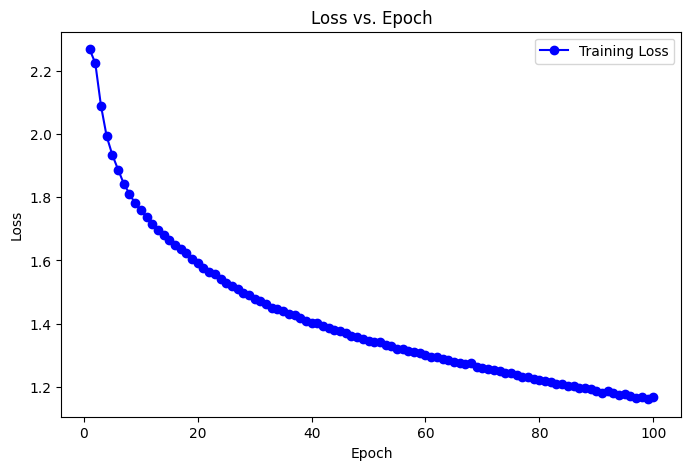

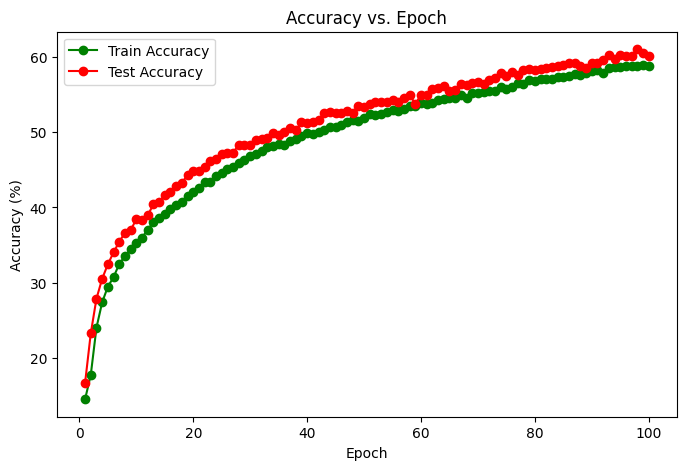

In [ ]:
# Plot Loss vs. Epoch
plt.figure(figsize=(8,5))
plt.plot(range(1, config.num_epochs+1), epoch_train_losses, marker="o", linestyle="-", color="blue", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

# Plot Accuracy vs. Epoch
plt.figure(figsize=(8,5))
plt.plot(range(1, config.num_epochs+1), epoch_train_accuracies, marker="o", linestyle="-", color="green", label="Train Accuracy")
plt.plot(range(1, config.num_epochs+1), epoch_test_accuracies, marker="o", linestyle="-", color="red", label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()